In [1]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt
import pandas as pd
# Provide complete installation or import information for external packages or modules here e.g.

#pip install somepackage
# from somepackage import blah


#!pip install yahoo_fin

import pandas as pd
from yahoo_fin.stock_info import get_data
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings("ignore")

#PAST DJIA
custom_tickers = [
    "^DJI",    # Dow Jones Industrial Average (DJI)
    "^GSPC",   # S&P 500
    "^IXIC",   # NASDAQ Composite
    "^FTSE",   # FTSE 100
    "^RUT",   # RUT
    #"^N225",
    #"^RMCC",
    #"^MID"
]


# Fetch data for each ticker
stock_data = {}
for ticker in custom_tickers:
    try:
        data = get_data(ticker)
        stock_data[ticker] = data
    except AssertionError as e:
        print(f"No data found for {ticker}: {e}")
        
sandp_time = stock_data["^IXIC"]

/Users/jasonmaytin/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
global lumpy_date
lumpy_date = None

def dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val):
    sandp_time.index = pd.to_datetime(sandp_time.index)

    def lump_sum_strategy(df, initial_investment, interval, moving_averages_df):
        total_investment = len(range(interval, len(df), interval)) * initial_investment
        initial_price = df['close'].iloc[0]  # First available closing price at testing start
        shares_owned = total_investment / initial_price  # Total shares bought at once
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(0)  # No additional investment made

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
    def lump_sum_with_delay_strategy(df, initial_investment, interval, moving_averages_df):
        global lumpy_date
        initial_in = len(range(interval, len(df), interval)) * initial_investment
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []
        remaining_investment = 0
        lump_sum_invested = False
        ma_value_peak = moving_averages_df.iloc[0]
        total_investment = 0
        ma_slope = np.gradient(moving_averages_df)

        days = 0
        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']

            if i >= len(df)-interval and not lump_sum_invested:
                shares_bought = initial_in / current_price
                shares_owned += shares_bought
                current_value = shares_owned * current_price
                portfolio_value.append(current_value)
                dates.append(df.index[i])
                investment_history.append(total_investment)
                lump_sum_invested = True
                days = 0
                lumpy_date = df.index[i]
            
            if not lump_sum_invested:
                if i >= 10000 or ((ma_slope[i] > slope_val) and days >= days_val):
                    shares_bought = initial_in / current_price
                    shares_owned += shares_bought
                    current_value = shares_owned * current_price
                    portfolio_value.append(current_value)
                    dates.append(df.index[i])
                    investment_history.append(total_investment)
                    lump_sum_invested = True
                    days = 0
                    lumpy_date = df.index[i]
                else:
                    if (ma_slope[i] > 0):
                        days += 1
                    else:
                        days = 0
                    total_investment = 0
            else:
                total_investment = 0

            shares_bought = total_investment / current_price if total_investment > 0 else 0
            shares_owned += shares_bought
            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(total_investment)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    def dca_strategy(df, investment_amount, interval):
        shares_owned = 0
        portfolio_value = []
        dates = []
        investment_history = []

        for i in range(0, len(df), interval):
            current_price = df.iloc[i]['close']
            shares_bought = investment_amount / current_price
            shares_owned += shares_bought

            current_value = shares_owned * current_price
            portfolio_value.append(current_value)
            dates.append(df.index[i])
            investment_history.append(investment_amount)

        return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    # Calculate moving averages for the testing dataset
    testing_df = sandp_time[start_date:end_date]
    full_set = sandp_time#[training_start_date:testing_end_date]
    moving_averages_test = full_set['close'].rolling(window=moving_average_window).mean()[start_date:end_date]
    
    
    # Calculate the investment strategy results on the testing dataset
    lump_sum_result = lump_sum_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    dca_result = dca_strategy(testing_df, initial_investment, time_interval)
    lump_sum_with_delay_result = lump_sum_with_delay_strategy(testing_df, initial_investment, time_interval, moving_averages_test)
    
    # Plotting
    if show_graph:
        plt.figure(figsize=(14, 8))
        plt.plot(testing_df.index, testing_df['close'], label='S&P Close', color='blue')
        plt.plot(testing_df.index, moving_averages_test, label='Moving Average', color='red')

        for date in lump_sum_with_delay_result.index[lump_sum_with_delay_result['investment_history'] > 0]:
            plt.axvline(x=date, color='purple', linestyle='--', linewidth=0.5, label='Investment Dates' if 'Investment Dates' not in plt.gca().get_legend_handles_labels()[1] else "")

        #plt.axvline(x=pd.to_datetime(start_date) + pd.DateOffset(years=1), color='green', linestyle='--', linewidth=0.5, label='Start Date')
        plt.axvline(x=lumpy_date, color='orange', linestyle='--', linewidth=0.5, label='Lump Sum Date')
        #print(start_date)
        #print(lumpy_date)
            
        plt.title('S&P Close and Moving Average Over Time')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

        # Plot DCA Strategy Performance
        fig, ax1 = plt.subplots(figsize=(14, 8))

        ax1.bar(lump_sum_with_delay_result.index.strftime('%Y-%m-%d'), lump_sum_with_delay_result['investment_history'], color='orange', label='Individual Investments')

        ax2 = ax1.twinx()

        ax2.plot(lump_sum_with_delay_result.index.strftime('%Y-%m-%d'), lump_sum_with_delay_result['portfolio_value'], label='Lump Sum w/ Delay Portfolio Value', color='blue')
        ax2.plot(dca_result.index.strftime('%Y-%m-%d'), dca_result['portfolio_value'], label='DCA Portfolio Value', color='red')
        ax2.plot(lump_sum_result.index.strftime('%Y-%m-%d'), lump_sum_result['portfolio_value'], label='Lump Sum Portfolio Value', color='black')
        
        ax1.set_title('Portfolio Value and Individual Investments Over Time')
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Individual Investments')
        ax2.set_ylabel('Portfolio Value')
        ax1.xaxis.set_tick_params(rotation=45)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper center')
        
        tick_frequency = 10
        ax1.xaxis.set_ticks(lump_sum_with_delay_result.index.strftime('%Y-%m-%d')[::tick_frequency])

        plt.show()

    lump_sum_with_delay_value = lump_sum_with_delay_result["portfolio_value"][-1]
    dca_value = dca_result["portfolio_value"][-1]
    lump_sum_value = lump_sum_result["portfolio_value"][-1]

    return [lump_sum_with_delay_value, dca_value, lump_sum_value,lumpy_date]

In [3]:
from datetime import datetime, timedelta

# Parameters
train_years = 1.5
test_years = 1

moving_average_window = 150
time_interval = 5
initial_investment = 10000
show_graph = False
slope_val = 0.001
days_val = 6


start_dates = np.random.choice(sandp_time.loc['2003-01-01':'2024-04-26'].index, size=2000, replace=False)
end_dates = [date + pd.DateOffset(months=int(test_years * 12)) for date in start_dates]


# Collect results
results = []
for start_date, end_date in zip(start_dates, end_dates):
    try:
        result = dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val)
        result_with_dates = result + [start_date, end_date]
        results.append(result_with_dates)
    except:
        pass

# Convert results into a DataFrame for easier manipulation
results_df = pd.DataFrame(results, columns=['Lump Sum with Delay', 'DCA', 'Lump Sum', 'Lump Sum Date','Start Date', 'End Date'])
results_df['Best Strategy'] = results_df[['Lump Sum with Delay', 'DCA', "Lump Sum"]].idxmax(axis=1)

In [4]:
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

def generate_features(data):
    features = pd.DataFrame(index=data.index)
    features['close'] = data['close']
    features['moving_average'] = data['close'].rolling(window=200).mean()
    features['volatility'] = data['close'].rolling(window=200).std()
    features['momentum'] = data['close'].pct_change(periods=10)
    features.dropna(inplace=True)
    return features

# Prepare dataset
features = generate_features(sandp_time)
results = pd.DataFrame(results_df, columns=['Start Date', 'End Date', 'Lump Sum with Delay', 'DCA', 'Lump Sum', 'Best Strategy', 'Lump Sum Date'])

# Merge features with results
data = features.join(results['Best Strategy']).dropna()
feature_periods = []

for idx, row in results.iterrows():
    #period_features = features.loc[row['Start Date']:row['End Date']]
    
    new_date = row['Lump Sum Date'] - timedelta(days=365 * train_years)
    period_features = features.loc[new_date:row['Lump Sum Date']]
    
    #period_features["close"] = MinMaxScaler().fit_transform(period_features[["close"]])
    #period_features["moving_average"] = MinMaxScaler().fit_transform(period_features[["moving_average"]])
    #period_features["volatility"] = MinMaxScaler().fit_transform(period_features[["volatility"]])
    #period_features["momentum"] = MinMaxScaler().fit_transform(period_features[["momentum"]])
    feature_periods.append(period_features)
    
results["data"] = pd.DataFrame(feature_periods)
#results = results[results["Best Strategy"] != "DCA"]
#results = results.reset_index(drop=True)
results[["Lump Sum with Delay", "DCA", "Lump Sum"]] = results[["Lump Sum with Delay", "DCA", "Lump Sum"]].apply(pd.to_numeric, errors='coerce')
results["ratio"] = results[["Lump Sum with Delay", "DCA", "Lump Sum"]].max(axis=1) / results[["Lump Sum with Delay", "DCA", "Lump Sum"]].apply(lambda x: x.nlargest(2).iloc[-1], axis=1)
results = results[results["ratio"] >= 1.02]

In [13]:
results

,Start Date,End Date,Lump Sum with Delay,DCA,Lump Sum,Best Strategy,Lump Sum Date,data,ratio
0,2015-03-04,2016-03-04,468230.502984,488707.285994,472062.390891,DCA,2015-04-16,close moving_average volat...,1.035260
1,2009-04-22,2010-04-22,695875.924401,618983.269850,759455.588296,Lump Sum,2009-07-02,close moving_average volat...,1.091366
2,2010-02-22,2011-02-22,579766.167787,599680.813777,630134.302768,Lump Sum,2010-04-06,close moving_average volat...,1.050783
3,2007-12-07,2008-12-07,500000.000000,340028.352276,267086.961884,Lump Sum with Delay,2008-12-04,close moving_average volat...,1.470466
4,2005-10-14,2006-10-14,523848.182494,540625.573438,568129.057324,Lump Sum,2005-11-28,close moving_average volat...,1.050873
...,...,...,...,...,...,...,...,...,...
1992,2017-09-05,2018-09-05,612164.562173,577295.440271,635985.508955,Lump Sum,2017-10-17,close moving_average volat...,1.038913
1993,2011-01-13,2012-01-13,487148.981000,517945.253375,495516.009464,DCA,2011-02-28,close moving_average volat...,1.045264
1994,2013-02-27,2014-02-27,649603.346192,597181.257632,677931.262848,Lump Sum,2013-04-11,close moving_average volat...,1.043608
1995,2003-02-07,2004-02-07,677209.325020,614693.361197,787371.285382,Lump Sum,2003-05-20,close moving_average volat...,1.162670


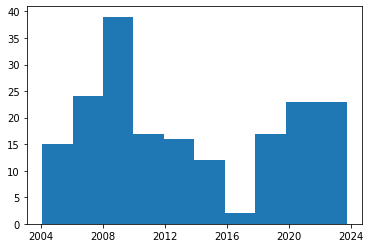

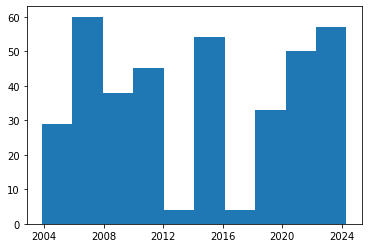

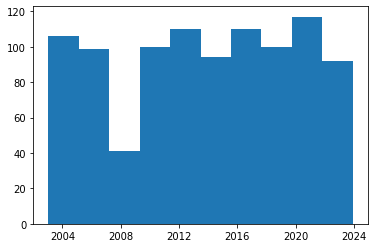

In [5]:
for i in ["Lump Sum with Delay", "DCA", "Lump Sum"]:
    plt.hist(results[results["Best Strategy"] == i]["Start Date"])
    plt.show()

In [27]:
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np


def flatten_features(df_list):
    return pd.concat([df.stack().reset_index(drop=True) for df in df_list], axis=1).T


flat_features = flatten_features(results['data']).dropna(axis=1)
labels = results['Best Strategy']

X_train, X_test, y_train, y_test = train_test_split(flat_features, labels, test_size=0.3, random_state=42)

svd = TruncatedSVD(n_components=50, random_state=42)
X_train_reduced = svd.fit_transform(X_train)
X_test_reduced = svd.transform(X_test)

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_reduced, y_train)

y_train_pred = classifier.predict(X_train_reduced)
y_pred = classifier.predict(X_test_reduced)

train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy of the model: {train_accuracy}")
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test accuracy of the model: {test_accuracy}")
print()

try:
    np.testing.assert_(train_accuracy >= 0.90, "Training accuracy is above 90%")
    print("Training accuracy assertion passed.")
except AssertionError as e:
    print(e)

try:
    np.testing.assert_(test_accuracy >= 0.80, "Test accuracy is above 80%")
    print("Test accuracy assertion passed.")
except AssertionError as e:
    print(e)

Training accuracy of the model: 0.9430438842203548
Test accuracy of the model: 0.9065217391304348

Training accuracy assertion passed.
Test accuracy assertion passed.


In [26]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming X_train, y_train, X_test, y_test are already defined

# Initialize and train the classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions
y_train_pred = classifier.predict(X_train)
y_pred = classifier.predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_pred)

# Print accuracies
print(f"Training accuracy of the model: {train_accuracy}")
print(f"Test accuracy of the model: {test_accuracy}")
print()

# Assert that accuracies are above a certain threshold
try:
    np.testing.assert_(train_accuracy >= 0.90, "Training accuracy is above 90%")
    print("Training accuracy assertion passed.")
except AssertionError as e:
    print(e)

try:
    np.testing.assert_(test_accuracy >= 0.80, "Test accuracy is above 80%")
    print("Test accuracy assertion passed.")
except AssertionError as e:
    print(e)

Training accuracy of the model: 0.9430438842203548
Test accuracy of the model: 0.9

Training accuracy assertion passed.
Test accuracy assertion passed.


In [33]:
print("{:<30} {:}".format("True", "Prediction"))
print("")
for i, j in zip(list(y_test), y_pred):
    print("{:<30} {:}".format(i, j))

True                           Prediction

Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum with Delay            Lump Sum with Delay
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
DCA                            DCA
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum with Delay
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
DCA                            DCA
DCA                            Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
Lump Sum                       Lump Sum
DCA                            Lump Sum
DCA                      

In [28]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_test, y_pred)

# Print the classification report
print(report)

                     precision    recall  f1-score   support

                DCA       0.95      0.72      0.82       109
           Lump Sum       0.88      0.99      0.93       294
Lump Sum with Delay       1.00      0.84      0.91        57

           accuracy                           0.91       460
          macro avg       0.94      0.85      0.89       460
       weighted avg       0.91      0.91      0.90       460



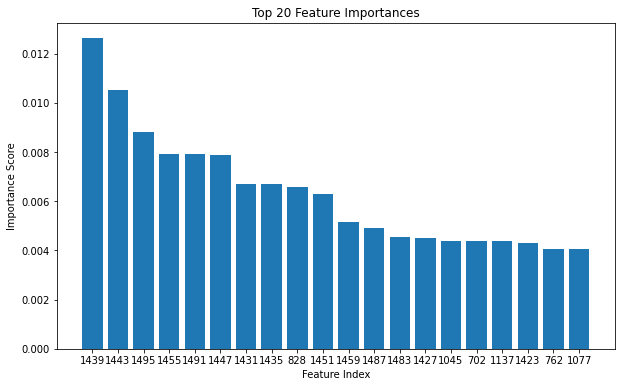

In [9]:
feature_importances = classifier.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Plot first 50 feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(20), feature_importances[indices[:20]], align="center")
plt.xticks(range(20), indices[:20])
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

[867, 91, 1769, 736, 1433, 1163, 1670, 1851, 1951, 60, 307, 381, 435, 155, 1522, 862, 1950, 926, 1460, 1981, 1836, 1560, 618, 794, 436, 689, 327, 1020, 1453, 62, 597, 424, 375, 1155, 29, 1845, 584, 1143, 1019, 722, 731, 1201, 1474, 1742, 1984, 513, 1463, 315, 1546, 1118, 153, 1815, 1408, 1479, 1361, 1889, 1656, 306, 450, 1835, 1971, 1307, 37, 1365, 422, 1127, 78, 441, 1622, 1544, 175, 1065, 1253, 655, 958, 345, 1675, 1465, 654, 816, 1385, 1331, 54, 1677, 339, 501, 140, 1402, 1325, 1057, 675, 539, 1570, 93, 1848, 1237, 1428, 820, 19, 1475, 1301, 1723, 1152, 448, 702, 256, 1041, 1604, 1702, 1658, 1078, 1205, 1819, 233, 69, 1506, 619, 476, 53, 681, 123, 745, 131, 1693, 1415, 279, 1245, 567, 1949, 1178, 161, 408, 369, 1904, 929, 894, 311, 1831, 931, 1533, 292, 1571, 776, 1552, 433, 1306, 1268, 1722, 508, 208, 1197, 378, 540, 778, 455, 1858, 1590, 1435, 242, 76, 1507, 1580, 1240, 1202, 344, 1807, 1181, 340, 274, 1062, 530, 1367, 1659, 1751, 1380, 1446, 1932, 1519, 1536, 1859, 1330, 1329, 80

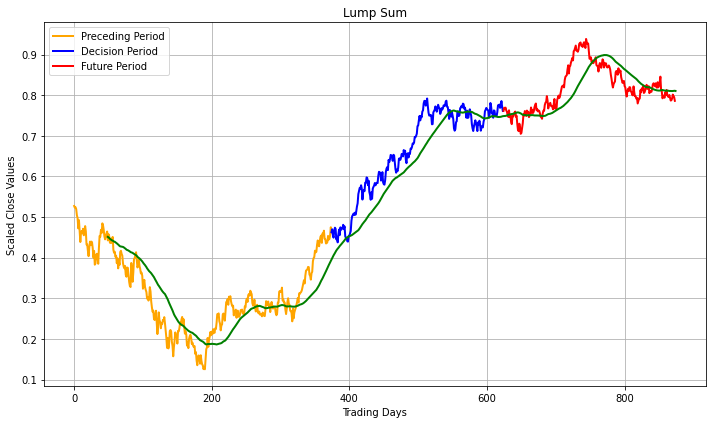

[390, 1214, 1757, 1300, 1728, 1711, 625, 1376, 1559, 892, 759, 1103, 613, 514, 1372, 1223, 1185, 1383, 1007, 708, 953, 875, 40, 631, 883, 1468, 933, 882, 571, 1627, 511, 347, 1642, 458, 1340, 888, 1721, 333, 547, 138, 710, 914, 1421, 1968, 686, 1442, 122, 1763]


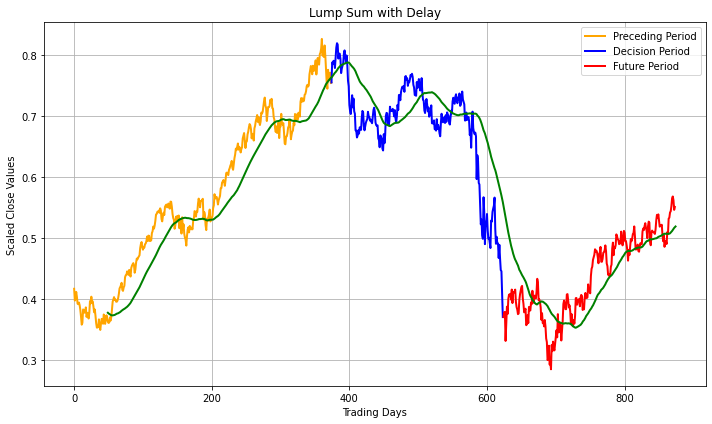

[1004, 1953, 38, 1459, 1597, 638, 1174, 1252, 329, 585, 214, 1926, 1925, 303, 121, 1052, 1776, 713, 1079, 1490, 1982, 1737, 1654, 1497, 1441, 221, 646, 1241, 609, 772, 1692, 1513, 1452, 1224, 250, 417, 742, 434, 398, 1832, 473, 984, 1427, 1549, 878, 1868, 1715, 1879, 382, 1220, 1171, 1472, 1423, 358, 1576, 1587, 1605, 39, 1323, 608, 1266, 828, 1114, 697, 1674, 941, 1607, 427, 897, 1669, 1242, 310, 832, 1486, 536, 1458, 763, 133]


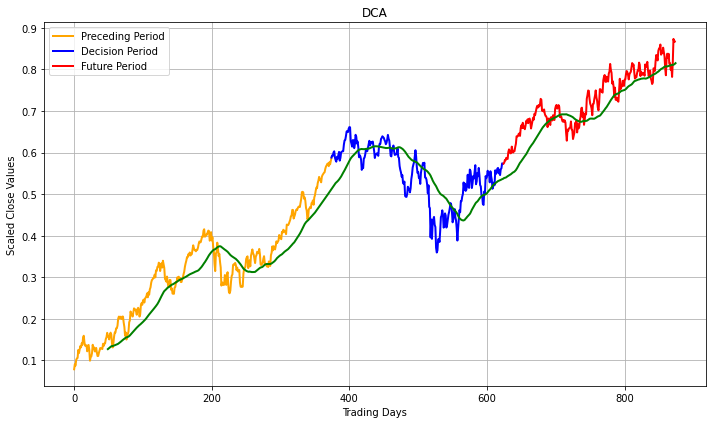

In [29]:
for strategy in ["Lump Sum", "Lump Sum with Delay", "DCA"]:
#for strategy in ["Lump Sum"]:
#for strategy in ["Lump Sum with Delay"]:
#for strategy in ["DCA"]:
    matching_delay_indices = []
    resetted_index = y_test.reset_index()

    # Iterate over the indices and the values of y_test and y_pred
    for idx, (actual, predicted) in enumerate(zip(y_test, y_pred)):
        if actual == predicted == strategy:
            matching_delay_indices.append(resetted_index.loc[idx]["index"])
    print(matching_delay_indices)

    start_dates = [results.loc[i]["Start Date"] for i in matching_delay_indices]
    end_dates = [results.loc[i]["End Date"] for i in matching_delay_indices]
    lump_sum_dates = [results.loc[i]["Lump Sum Date"] for i in matching_delay_indices] 
    show_graph = True

    final_1 = [0.5] * int(int(train_years * 12)*250/12)   # Initialize final variable for the first line
    final_2 = [0.5] * int(int(test_years * 12)*250/12)    # Initialize final variable for the second line
    final_3 = [0.5] * int(int(test_years * 12)*250/12)

#     for start_date, end_date, lump_sum_date in zip(start_dates, end_dates, lump_sum_dates):
#         # Calculate the data for final_1
#         new_date = (start_date - timedelta(days=365 * train_years))
#         data = sandp_time['close'][new_date:start_date]
#         scaled = (data - data.min()) / (data.max() - data.min())
#         scaled = np.array(scaled)[len(scaled)-len(final_1):]
#         if len(scaled) == len(final_1):
#             final_1 = (final_1 + scaled) / 2  # Aggregate with the first final variable

#         # Calculate the data for final_2
#         end_data = sandp_time['close'][start_date:start_date + timedelta(days=365 * test_years)]
#         scaled_end = (end_data - end_data.min()) / (end_data.max() - end_data.min())
#         scaled_end = np.array(scaled_end)[len(scaled_end)-len(final_2):]
#         if len(scaled_end) == len(final_2):
#             final_2 = (final_2 + scaled_end) / 2  # Aggregate with the second final variable

#         # Calculate the data for final_3
#         future_date = (end_date + timedelta(days=365 * test_years))
#         data = sandp_time['close'][end_date:future_date]
#         scaled = (data - data.min()) / (data.max() - data.min())
#         scaled = np.array(scaled)[len(scaled)-len(final_3):]
#         if len(scaled) == len(final_3):
#             final_3 = (final_3 + scaled) / 2

#         # Concatenate all three variables
#         combined_data = np.concatenate([final_1, final_2, final_3])

#         # Calculate the minimum and maximum values from the combined data
#         min_value = np.min(combined_data)
#         max_value = np.max(combined_data)

#         # Scale each variable based on the combined minimum and maximum values
#         final_1 = (final_1 - min_value) / (max_value - min_value)
#         final_2 = (final_2 - min_value) / (max_value - min_value)
#         final_3 = (final_3 - min_value) / (max_value - min_value)

    for start_date, end_date, lump_sum_date in zip(start_dates, end_dates, lump_sum_dates):
        # Calculate data for final_1
        new_date = start_date - timedelta(days=365 * train_years)
        data_1 = np.array(sandp_time['close'][new_date:start_date])
        data_1 = data_1[len(data_1)-len(final_1):]
        if len(data_1) < len(final_1):
            continue  # Skip if data length is insufficient

        # Calculate data for final_2
        data_2 = np.array(sandp_time['close'][start_date:end_date])
        data_2 = data_2[len(data_2)-len(final_2):]
        if len(data_2) < len(final_2):
            continue  # Skip if data length is insufficient

        # Calculate data for final_3
        future_date = end_date + timedelta(days=365 * test_years)
        data_3 = np.array(sandp_time['close'][end_date:future_date])
        data_3 = data_3[len(data_3)-len(final_3):]
        if len(data_3) < len(final_3):
            continue  # Skip if data length is insufficient

        # Find min and max values across the data sets for this iteration
        combined_data = np.concatenate([data_1, data_2, data_3])
        min_value = np.min(combined_data)
        max_value = np.max(combined_data)

        # Scale the data
        scaled_data_1 = (data_1 - min_value) / (max_value - min_value)
        scaled_data_2 = (data_2 - min_value) / (max_value - min_value)
        scaled_data_3 = (data_3 - min_value) / (max_value - min_value)

        # Update final variables by averaging scaled data with the current values
        final_1 = (final_1 + scaled_data_1[:len(final_1)]) / 2
        final_2 = (final_2 + scaled_data_2[:len(final_2)]) / 2
        final_3 = (final_3 + scaled_data_3[:len(final_3)]) / 2
    

    # Plot the first line
    final_2 = final_2+(final_1[-1]-final_2[0])
    final_3 = final_3+(final_2[-1]-final_3[0])
    
    plt.figure(figsize=(10, 6))
    plt.plot(final_1, color='orange', linewidth=2, linestyle='-')
    
    # Plot the second line
    plt.plot(range(len(final_1) - 1, len(final_1) + len(final_2) - 1), final_2, color='blue', linewidth=2, linestyle='-')

    plt.plot(range(len(final_1) + len(final_2) - 1, len(final_1) + len(final_2) + len(final_3) - 1), final_3, color='red', linewidth=2, linestyle='-')

    
    combined_final = np.concatenate([final_1,final_2,final_3])
    moving_average = pd.Series(combined_final).rolling(window=50).mean()
    plt.plot(moving_average, color='green', linestyle='-', linewidth=2)

    
    plt.title(strategy)
    plt.xlabel('Trading Days')
    plt.ylabel('Scaled Close Values')
    plt.grid(True)
    plt.tight_layout()
    plt.legend(['Preceding Period', 'Decision Period','Future Period'], loc='best')
    plt.show()

Initial Date : 2007-12-11
Start Date   : 2008-06-13 00:00:00
Lump Sum Date: 2009-06-11
End Date     : 2009-06-13


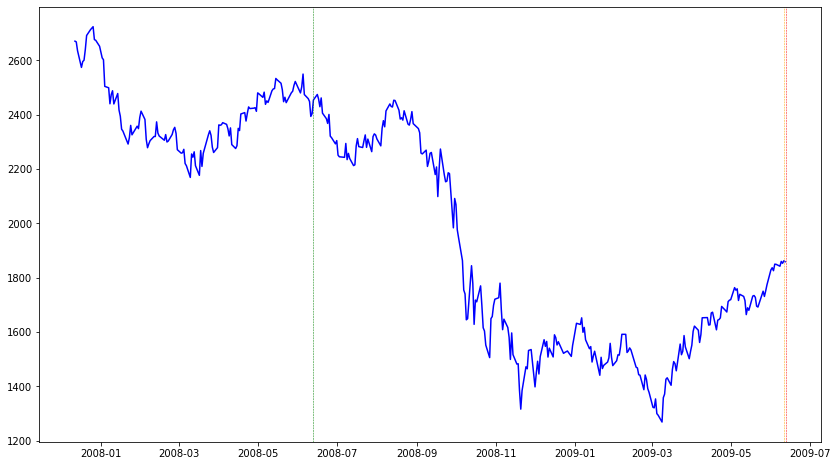

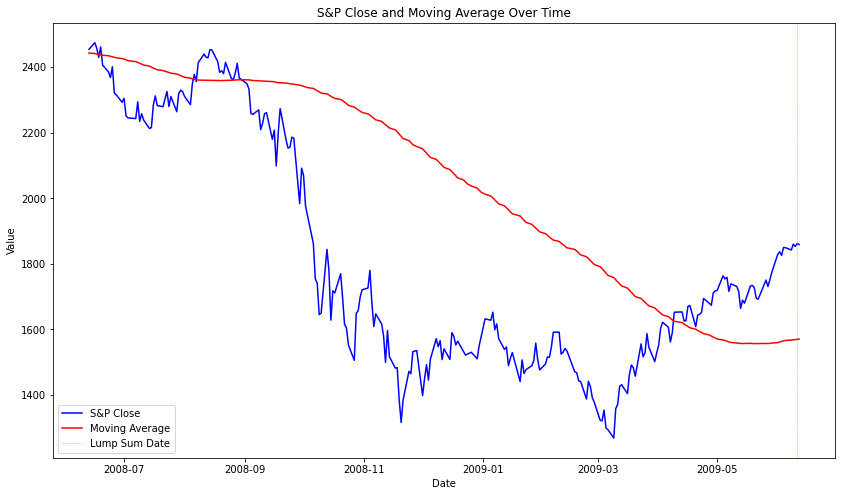

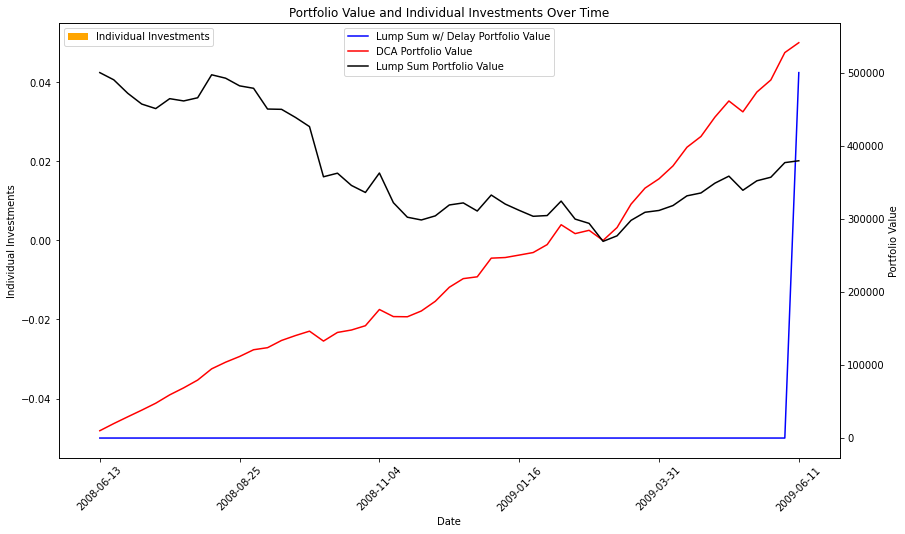

Initial Date : 1986-02-05
Start Date   : 1987-06-25 00:00:00
Lump Sum Date: 1987-08-07
End Date     : 1988-06-25


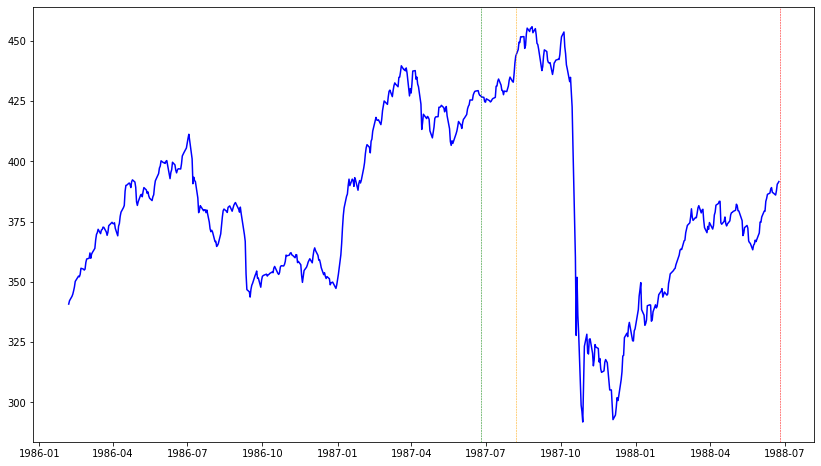

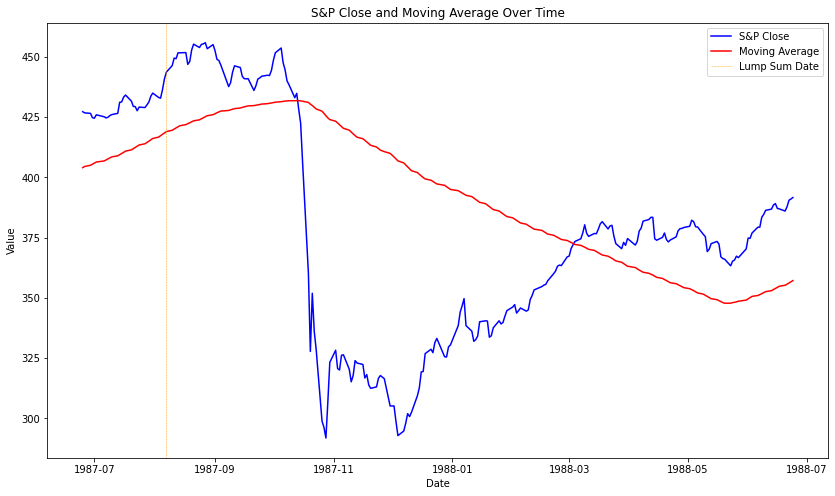

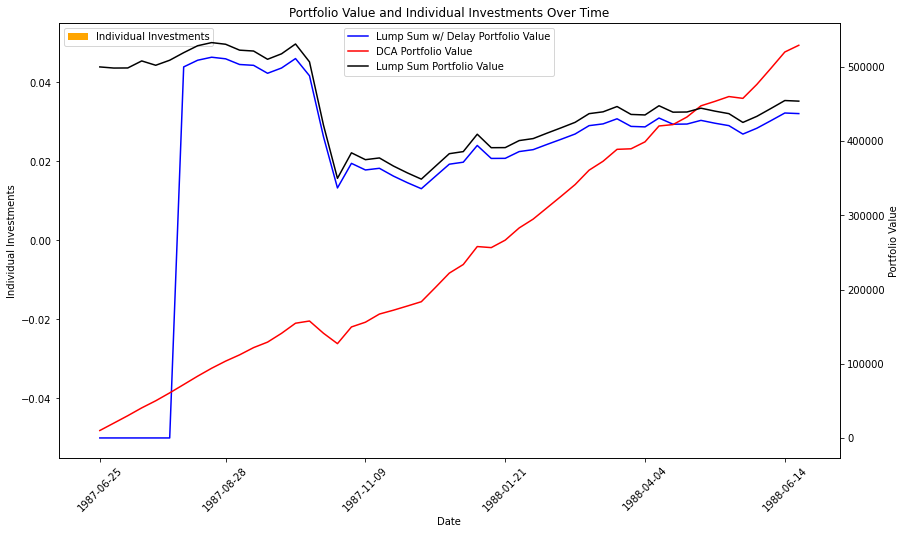

Initial Date : 1982-05-08
Start Date   : 1983-09-26 00:00:00
Lump Sum Date: 1983-11-07
End Date     : 1984-09-26


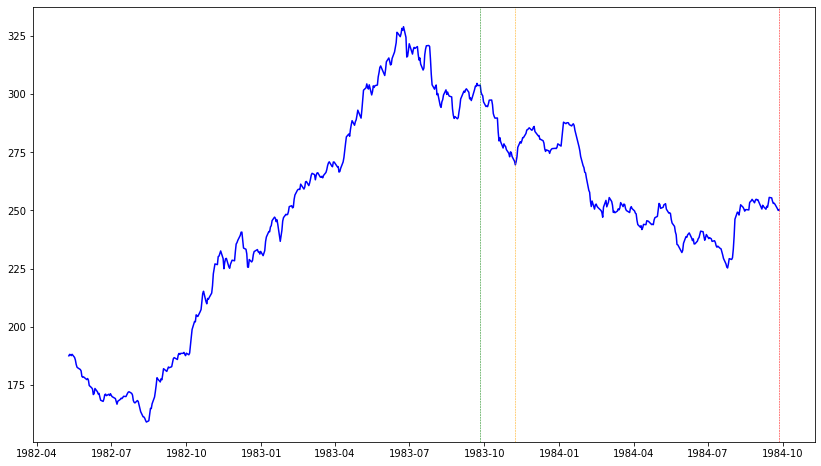

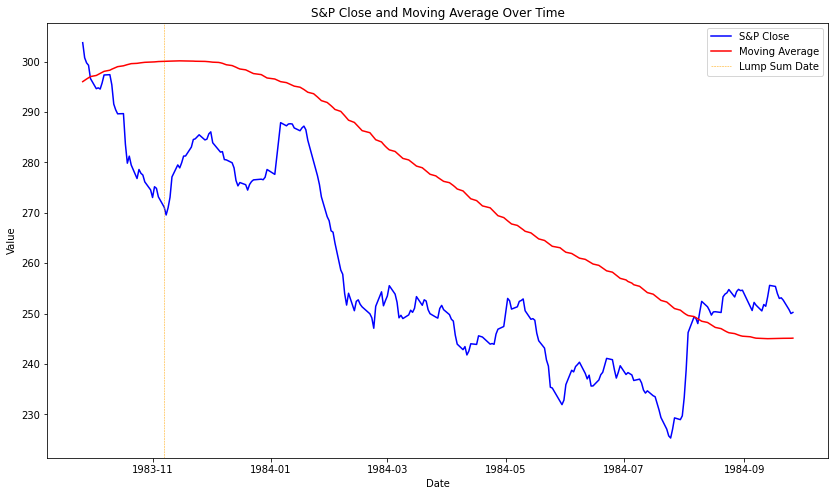

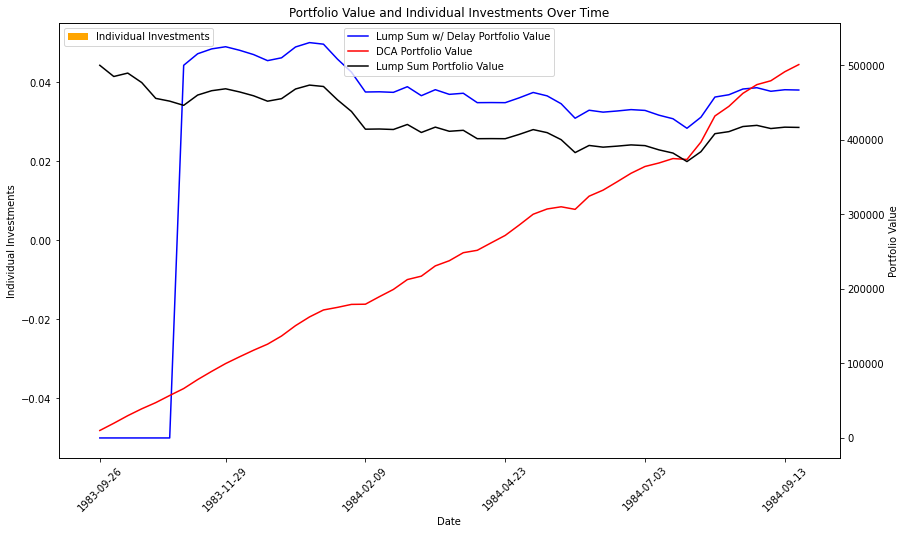

Initial Date : 1989-01-17
Start Date   : 1990-01-19 00:00:00
Lump Sum Date: 1990-07-19
End Date     : 1991-01-19


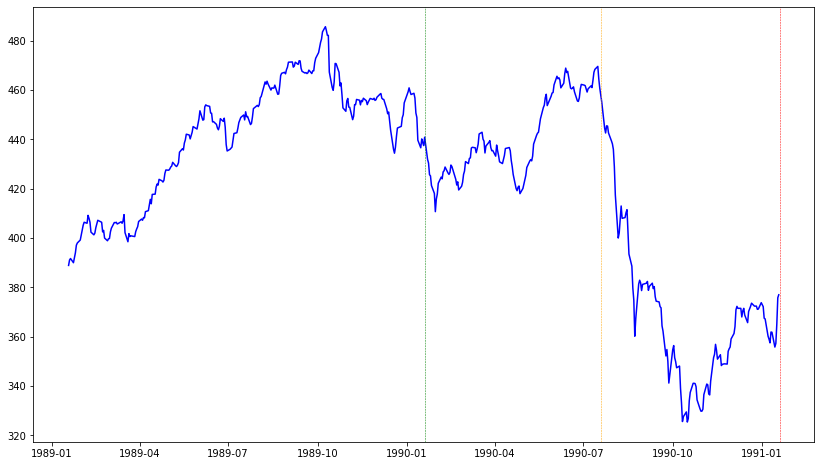

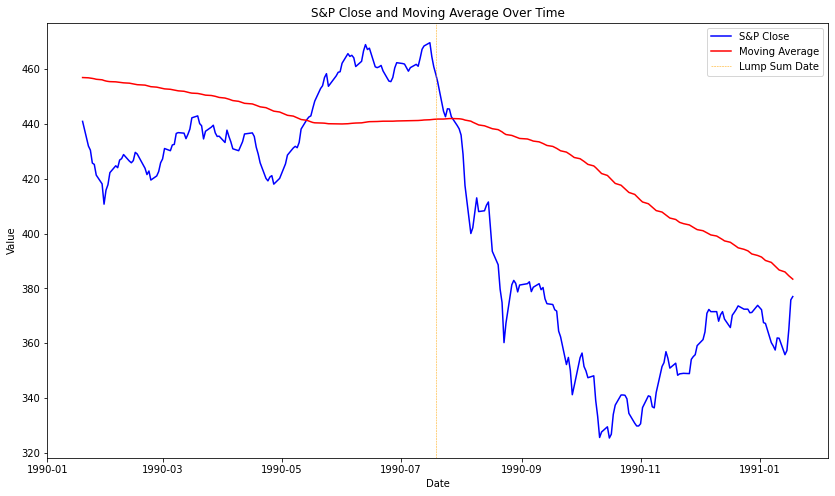

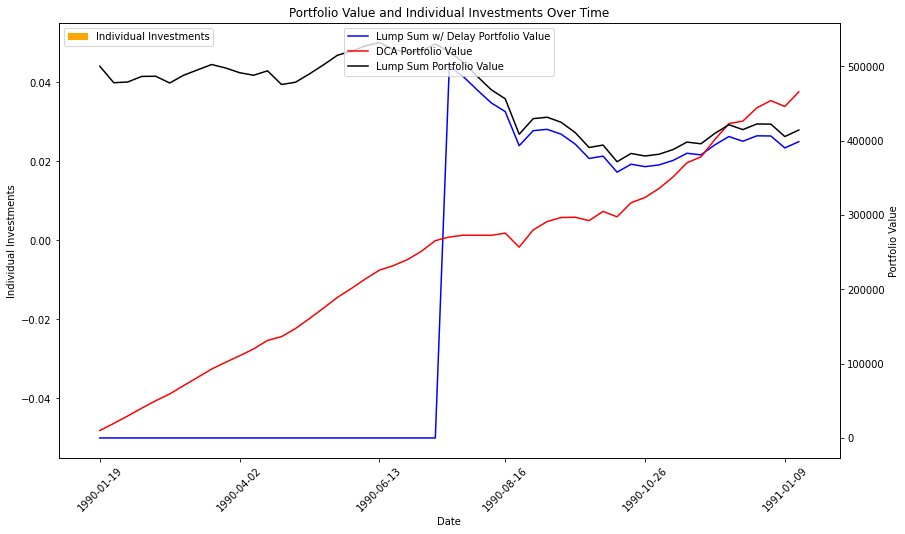

Initial Date : 1985-12-17
Start Date   : 1987-05-06 00:00:00
Lump Sum Date: 1987-06-18
End Date     : 1988-05-06


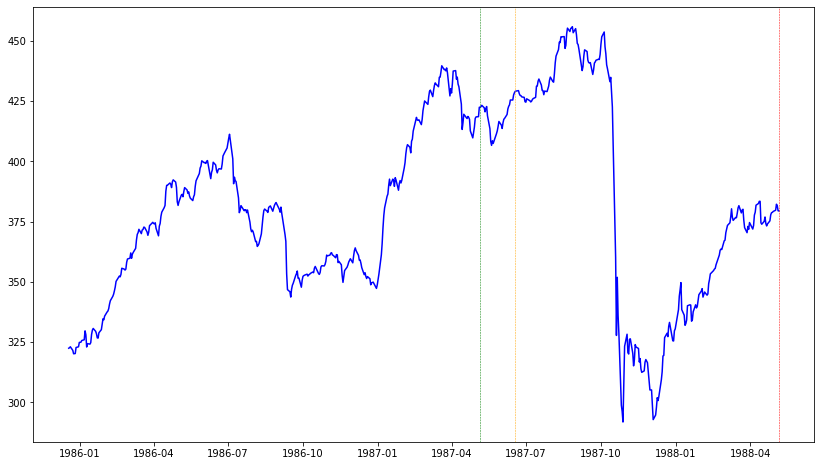

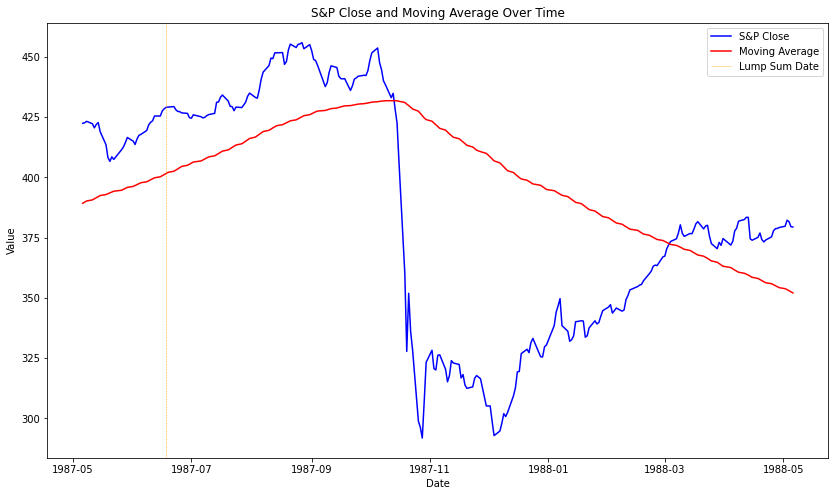

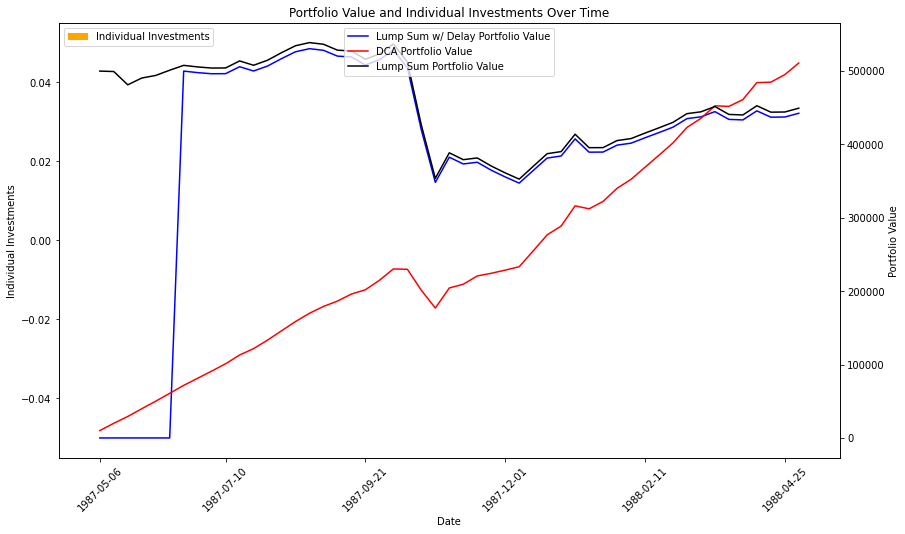

Initial Date : 1986-02-01
Start Date   : 1987-06-19 00:00:00
Lump Sum Date: 1987-08-03
End Date     : 1988-06-19


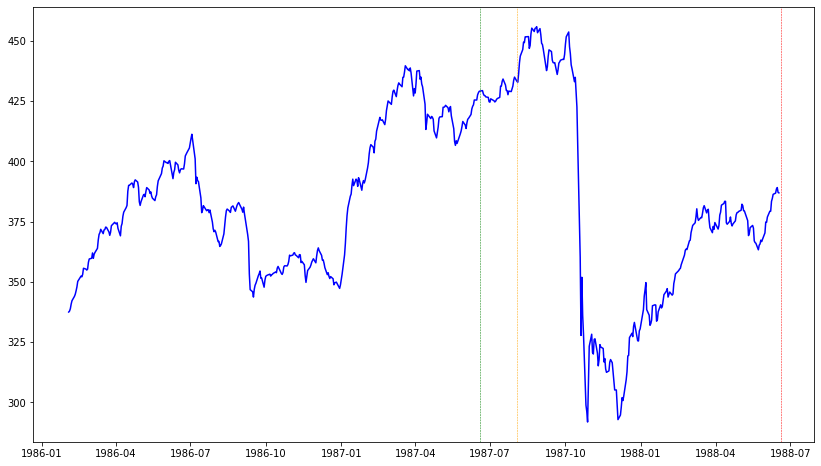

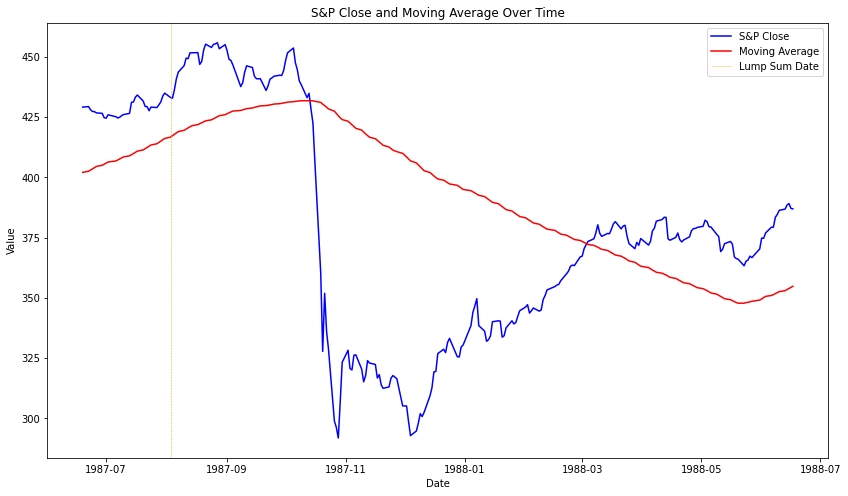

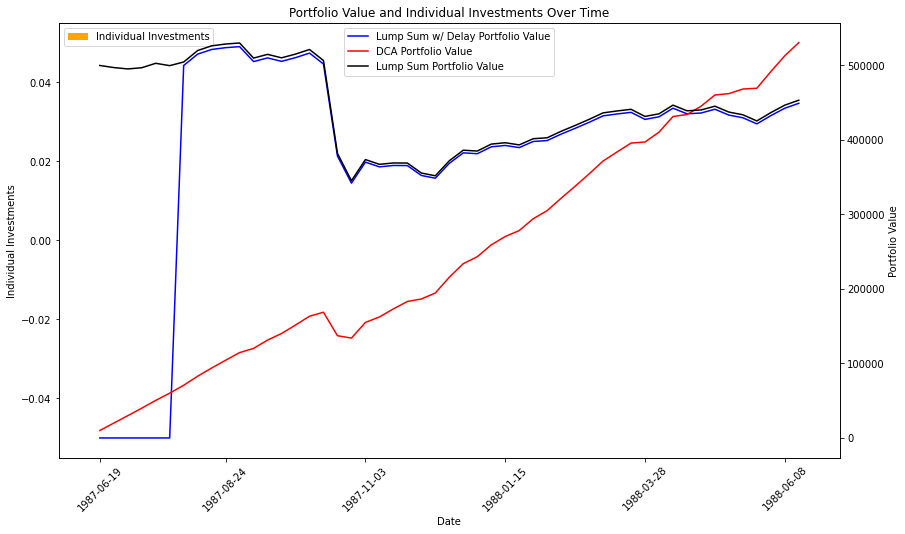

Initial Date : 2014-01-25
Start Date   : 2015-06-12 00:00:00
Lump Sum Date: 2015-07-27
End Date     : 2016-06-12


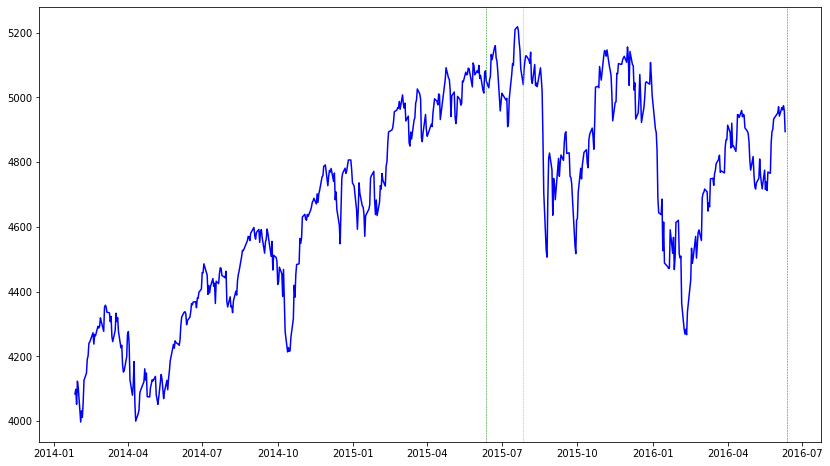

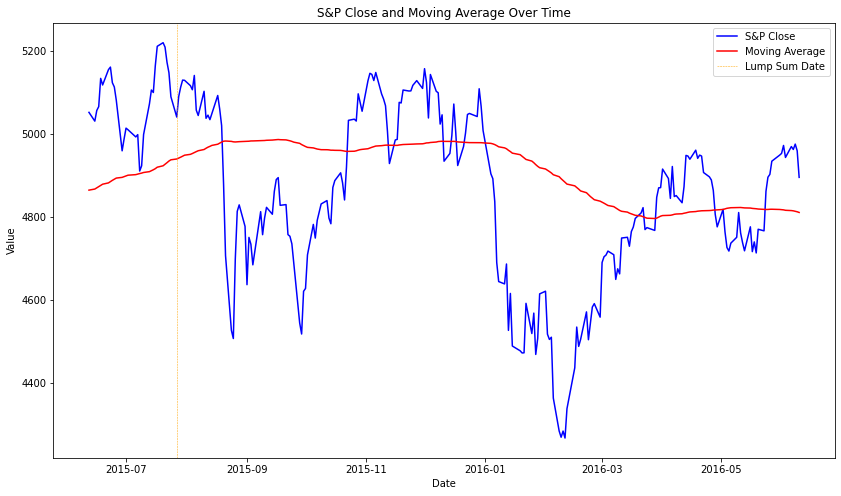

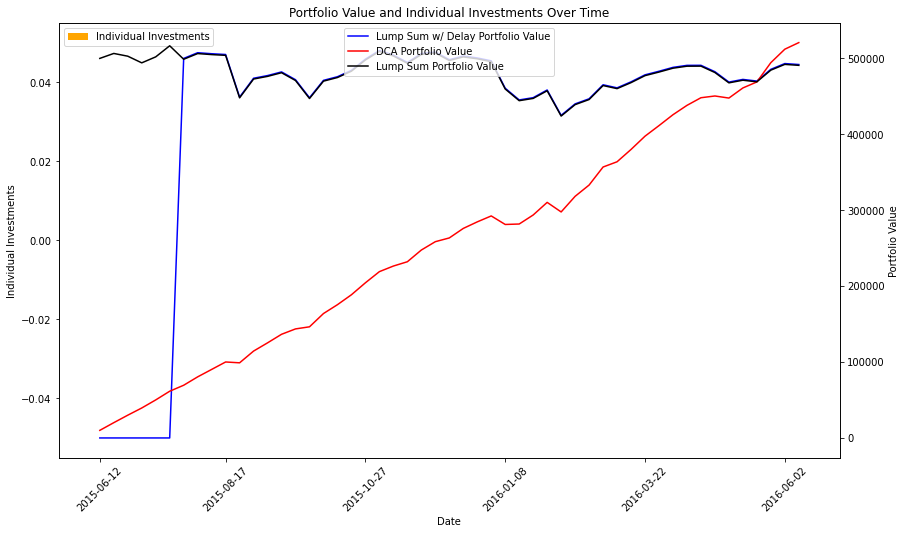

Initial Date : 2020-03-02
Start Date   : 2021-07-21 00:00:00
Lump Sum Date: 2021-09-01
End Date     : 2022-07-21


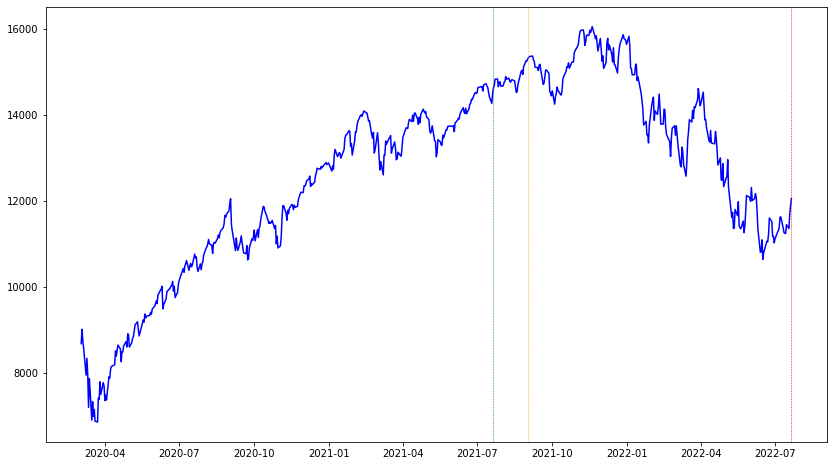

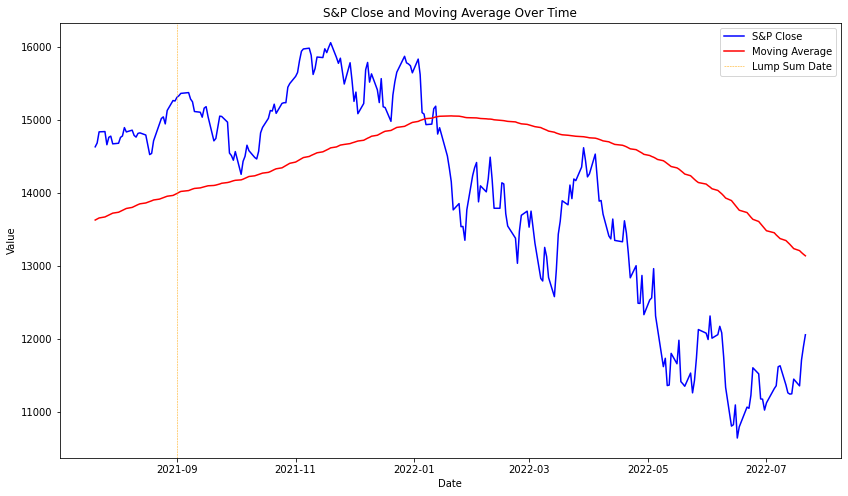

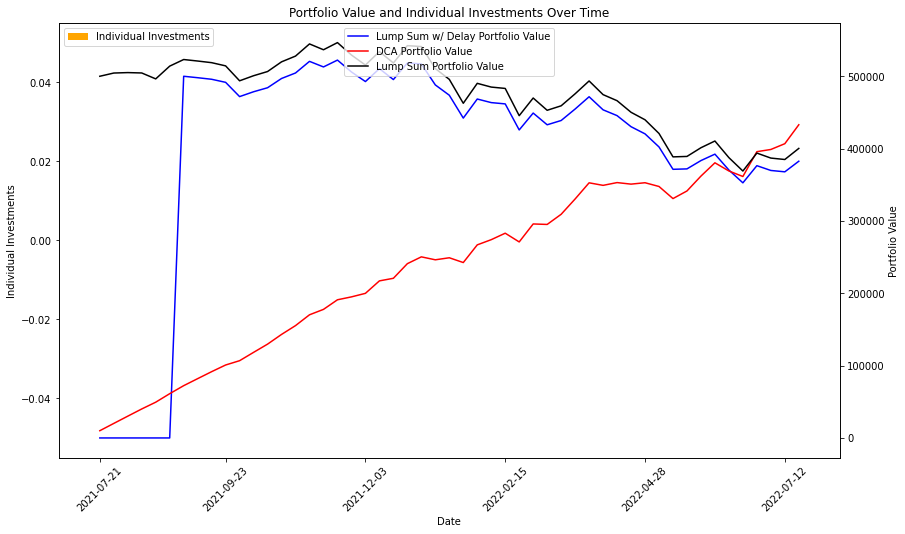

Initial Date : 1992-07-04
Start Date   : 1993-11-18 00:00:00
Lump Sum Date: 1994-01-03
End Date     : 1994-11-18


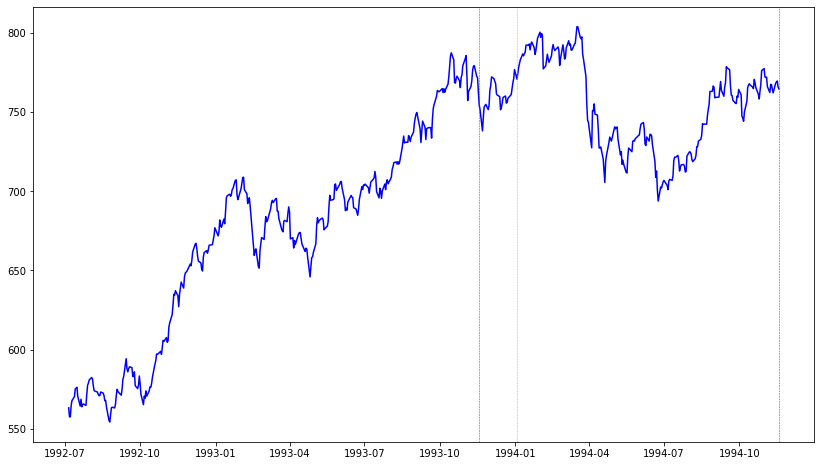

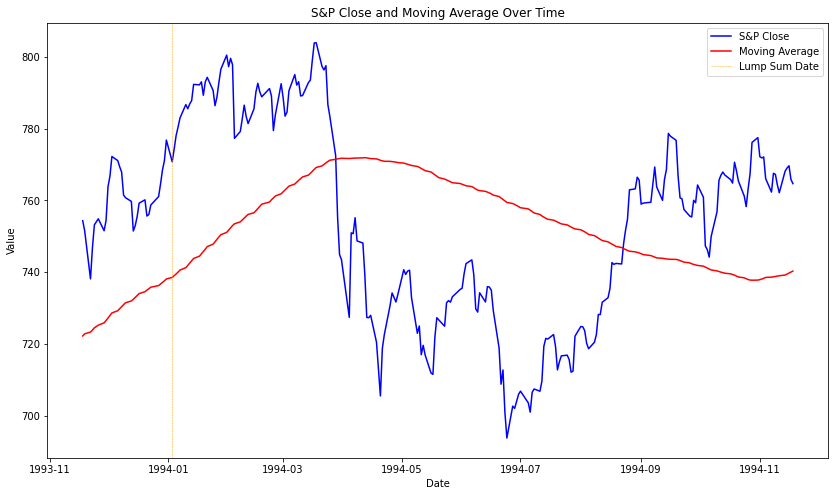

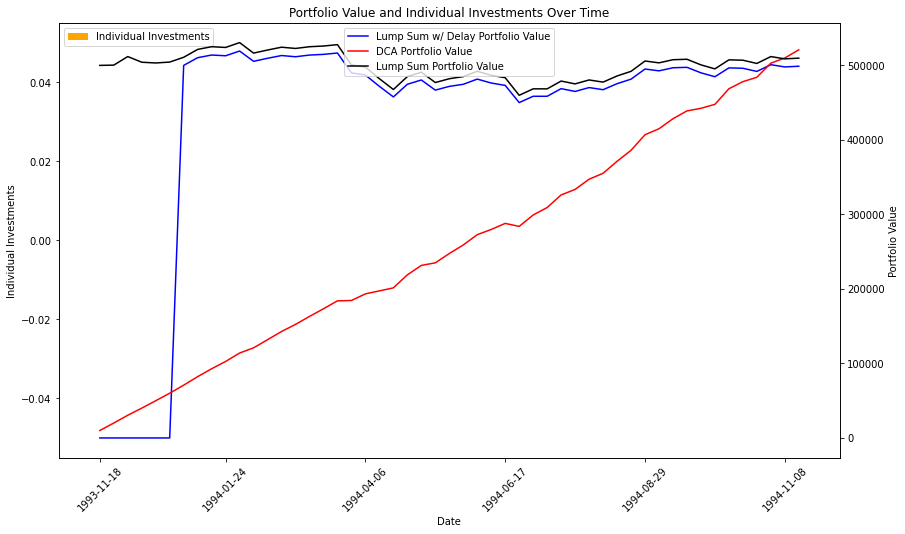

Initial Date : 2021-08-09
Start Date   : 2022-02-09 00:00:00
Lump Sum Date: 2023-02-08
End Date     : 2023-02-09


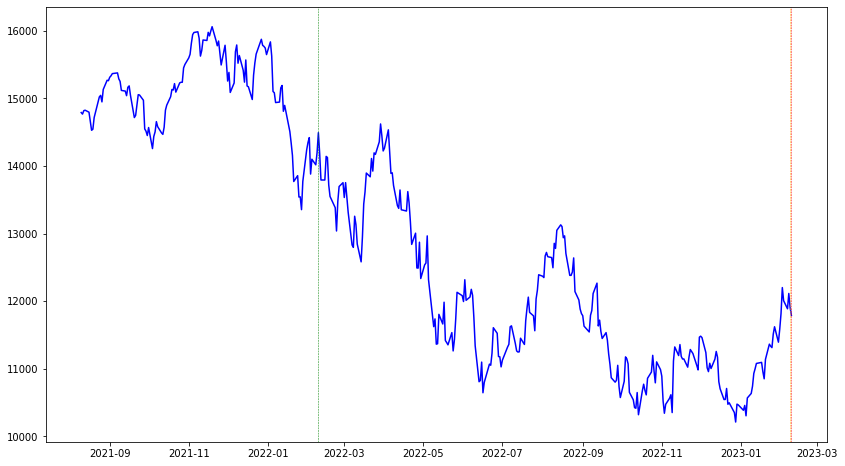

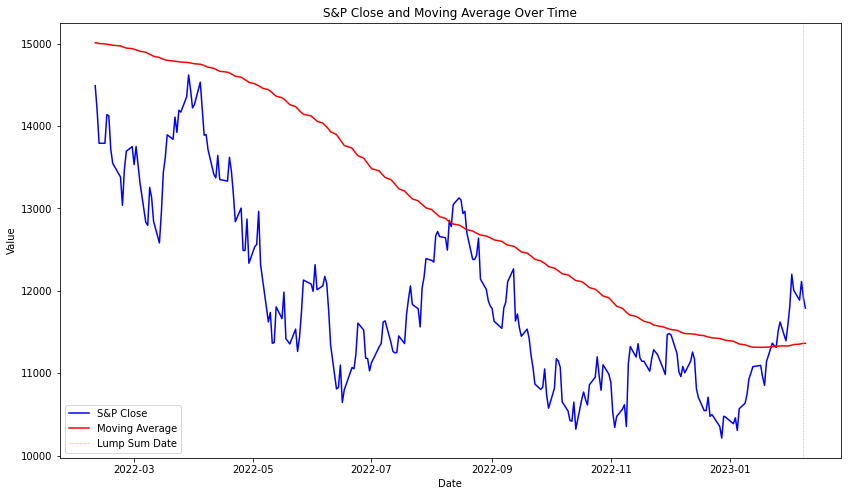

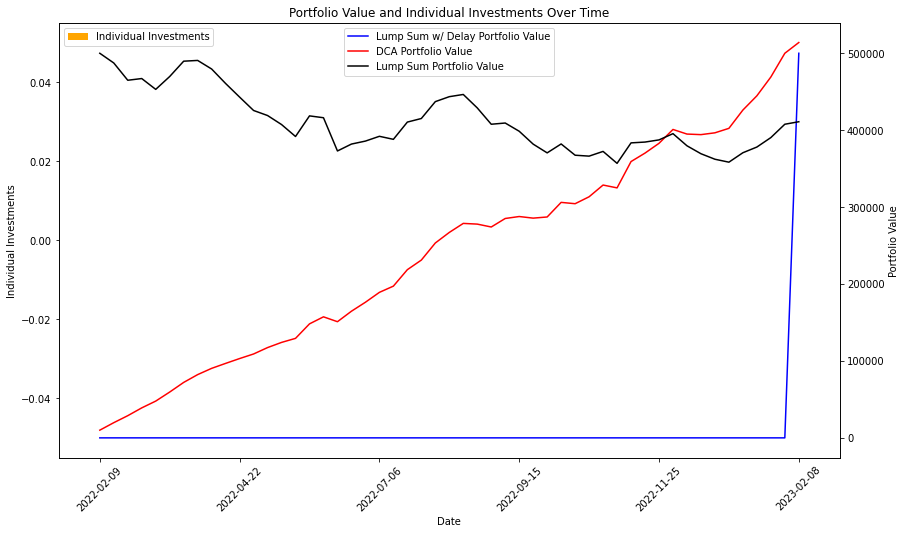

Initial Date : 2014-06-09
Start Date   : 2015-08-03 00:00:00
Lump Sum Date: 2015-12-09
End Date     : 2016-08-03


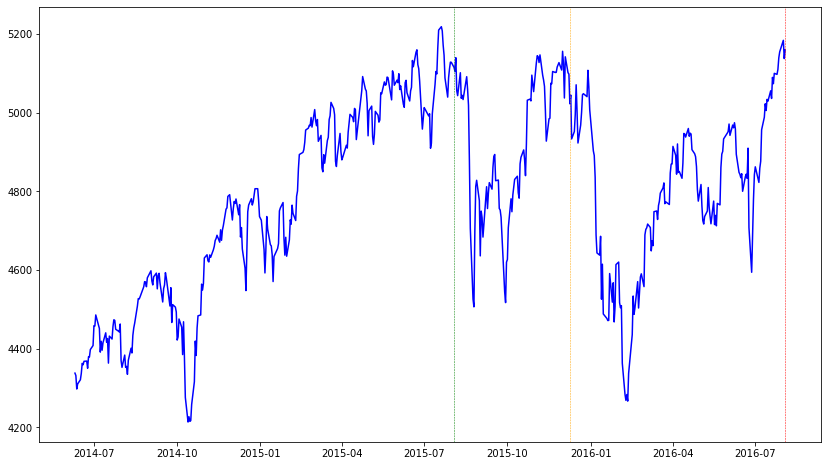

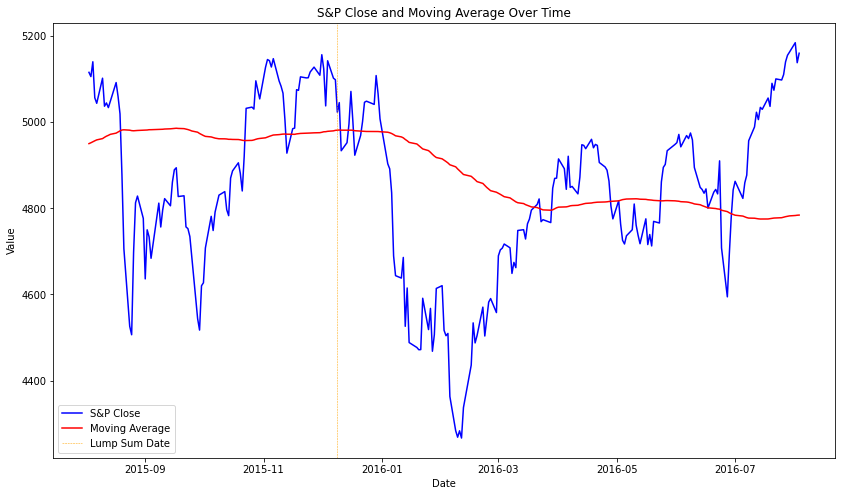

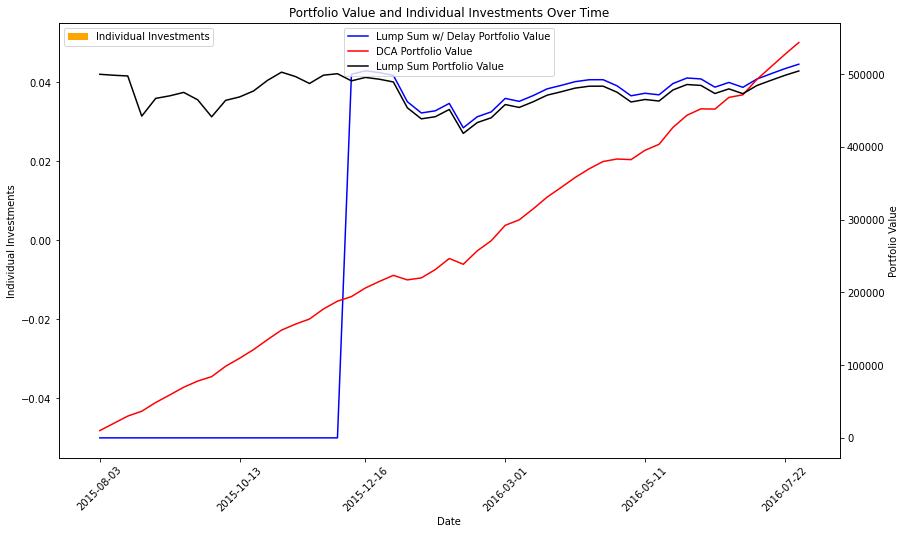

Initial Date : 2006-04-10
Start Date   : 2007-08-28 00:00:00
Lump Sum Date: 2007-10-10
End Date     : 2008-08-28


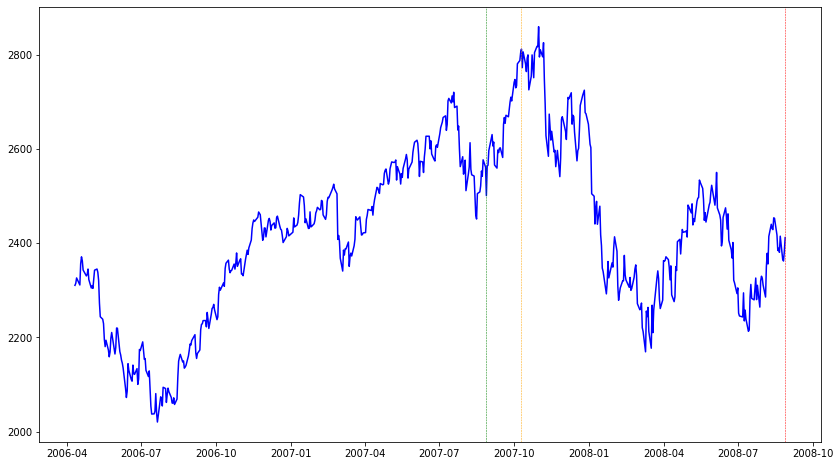

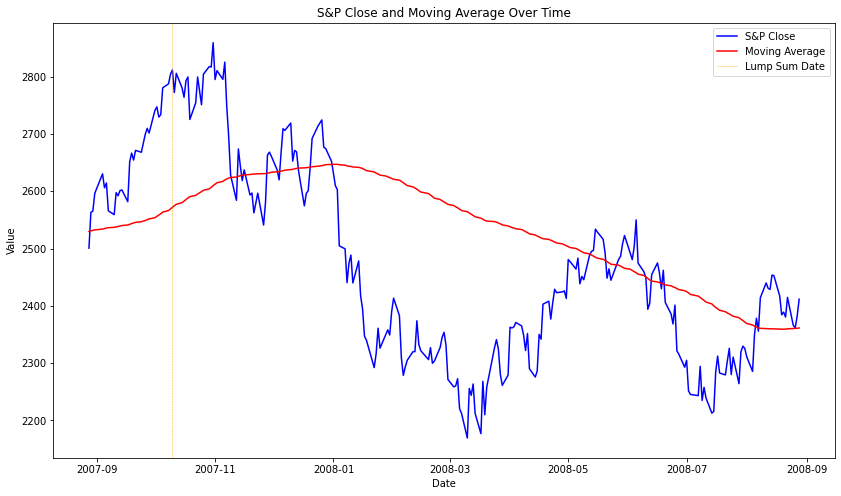

KeyboardInterrupt: 

In [126]:
import matplotlib.pyplot as plt
from datetime import timedelta

start_dates = [results.loc[i]["Start Date"] for i in matching_delay_indices]
end_dates = [results.loc[i]["End Date"] for i in matching_delay_indices]
lump_sum_dates = [results.loc[i]["Lump Sum Date"] for i in matching_delay_indices]  # Extract lump sum dates
show_graph = True

for start_date, end_date, lump_sum_date in zip(start_dates, end_dates, lump_sum_dates):
    print("Initial Date :", (lump_sum_date - timedelta(days=365 * train_years)).strftime('%Y-%m-%d'))
    print("Start Date   :", start_date)
    print("Lump Sum Date:", lump_sum_date.strftime('%Y-%m-%d'))
    print("End Date     :", end_date.strftime('%Y-%m-%d'))

    new_date = (lump_sum_date - timedelta(days=365 * train_years))

    # Plot size
    plt.figure(figsize=(14, 8))

    # Plot S&P Close
    plt.plot(sandp_time['close'][new_date:end_date], label='S&P Close', color='blue')

    # Plot vertical lines for start_date, lump_sum_date, and end_date
    plt.axvline(x=start_date, color='green', linestyle='--', linewidth=0.5)
    plt.axvline(x=lump_sum_date, color='orange', linestyle='--', linewidth=0.5)
    plt.axvline(x=end_date, color='red', linestyle='--', linewidth=0.5)

    # Plotting DCA analysis
    result = dca_analysis(sandp_time, moving_average_window, time_interval, start_date, end_date, initial_investment, show_graph, slope_val, days_val)



This function, `dca_analysis`, conducts an analysis of Dollar Cost Averaging (DCA) investment strategies using historical market data. Here's a breakdown of what it does:

1. **Data Preparation**:
   - The function takes in various parameters such as `sandp_time` (historical market data), `trendline_multiplier`, `moving_average_window`, `time_interval`, `training_start_date`, `training_end_date`, `testing_start_date`, `testing_end_date`, `max_val`, and `show_graph`.

2. **Data Processing**:
   - The function preprocesses the historical market data and fits a trendline to it using the exponential function.
   - It splits the dataset into training and testing periods according to the provided dates.

3. **Dollar Cost Averaging Strategies**:
   - The function implements three different DCA strategies: original DCA strategy, DCA with complete rollover strategy, and DCA with risk-based rollover strategy.

4. **Graphical Visualization**:
   - If `show_graph` is set to `True`, the function generates two plots:
     - The first plot shows the in-sample and out-of-sample market data along with the trendlines and moving averages.
     - The second plot displays the portfolio value and individual investments over time for each DCA strategy.

5. **Result Evaluation**:
   - The function prints the final portfolio values for each DCA strategy and calculates the percentage difference between the portfolio values obtained using different strategies.

6. **Parameter Definition**:
   - Finally, the function defines parameters such as `moving_average`, `time_interv`, `training_start_date`, `training_end_date`, `testing_start_date`, and `testing_end_date`, which are used in the analysis.

Overall, this function provides a comprehensive analysis of different DCA strategies and their performance using historical market data, helping investors make informed decisions.


In [ ]:
# def dca_analysis(sandp_time, trendline_multiplier, moving_average_window, time_interval, training_start_date, training_end_date, testing_start_date, testing_end_date, max_val, show_graph):
#     sandp_time.index = pd.to_datetime(sandp_time.index)
    
#     def dca_with_complete_rollover_strategy(df, investment_amount, interval, moving_averages_df, trendline_multiplier):
#         shares_owned = 0
#         portfolio_value = []
#         dates = []
#         investment_history = []
#         aggregated_investment = 0

#         for i in range(0, len(df), interval):
#             current_price = df.iloc[i]['close']
#             ma_value = moving_averages_df['Moving Average'][i]
#             trendline_value = df['Trendline'][i]
    
#             invested_period = investment_amount + aggregated_investment
            
#             if ma_value * trendline_multiplier < trendline_value or i >= (len(df) - interval - 2):
#                 shares_bought = invested_period / current_price
#                 shares_owned += shares_bought
                
#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
                
#                 investment_history.append(invested_period)
#                 aggregated_investment = 0 
#             else:
#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
#                 investment_history.append(0)

#                 aggregated_investment += investment_amount

#         return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
#     def dca_with_risk_based_rollover_strategy(df, initial_investment, interval, moving_averages_df, trendline_multiplier):
#         shares_owned = 0
#         portfolio_value = []
#         dates = []
#         investment_history = []
#         remaining_investment = 0

#         for i in range(0, len(df), interval):
#             current_price = df.iloc[i]['close']
#             ma_value = moving_averages_df['Moving Average'][i]
#             trendline_value = df['Trendline'][i]

#             if ma_value * trendline_multiplier < trendline_value or i >= (len(df) - interval - 2):
#                 total_investment = remaining_investment + initial_investment
#                 shares_bought = total_investment / current_price
                
#                 shares_owned += shares_bought
#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
#                 investment_history.append(total_investment)
#                 remaining_investment = 0
#             else:
#                 distance_percentage = (ma_value - trendline_value) / trendline_value
#                 adjustment_factor = max(1 - distance_percentage * max_val/2, 0)
            
#                 amount_to_invest = initial_investment * adjustment_factor
#                 shares_bought = amount_to_invest / current_price
#                 shares_owned += shares_bought

#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
#                 investment_history.append(amount_to_invest)
#                 remaining_investment += initial_investment - amount_to_invest

#         return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
#     def original_dca_strategy(df, investment_amount, interval):
#         shares_owned = 0
#         portfolio_value = []
#         dates = []
#         investment_history = []

#         for i in range(0, len(df), interval):
#             current_price = df.iloc[i]['close']
#             shares_bought = investment_amount / current_price
#             shares_owned += shares_bought

#             current_value = shares_owned * current_price
#             portfolio_value.append(current_value)
#             dates.append(df.index[i])
#             investment_history.append(investment_amount)

#         return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)
    
#     # Split the dataset into in-sample (training) and out-of-sample (testing)
#     training_df = sandp_time[training_start_date:training_end_date]
#     testing_df = sandp_time[testing_start_date:testing_end_date]

#     # Fit the curve on the training dataset
#     def exponential_func(x, a, b):
#         return a * np.exp(b * x)
    
#     x_values_train = np.arange(len(training_df))
#     y_values_train = training_df['close']
#     initial_guess = (1.0, 0.001)
#     popt, pcov = curve_fit(exponential_func, x_values_train, y_values_train, p0=initial_guess)
#     trendline_train = exponential_func(x_values_train, *popt)

#     # Apply the trendline to the testing dataset
#     x_values_test = np.arange(len(testing_df)) + len(training_df)
#     trendline_test = exponential_func(x_values_test, *popt)
#     testing_df['Trendline'] = trendline_test

#     # Calculate moving averages for the testing dataset
#     moving_averages_test = pd.DataFrame()
#     full_set = sandp_time[training_start_date:testing_end_date]
#     moving_averages_test['Moving Average'] = full_set['close'].rolling(window=moving_average_window).mean()[len(full_set)-len(testing_df):]

#     # Calculate the investment strategy results on the testing dataset
#     custom_result = dca_with_complete_rollover_strategy(testing_df, 8 * time_interval, time_interval, moving_averages_test, trendline_multiplier)
#     original_result = original_dca_strategy(testing_df, 8 * time_interval, time_interval)
#     second_custom_result = dca_with_risk_based_rollover_strategy(testing_df, 8 * time_interval, time_interval, moving_averages_test, trendline_multiplier)

    
    
#     # Plotting
#     if show_graph:
#         plt.figure(figsize=(14, 8))
#         # Plot in-sample data
#         plt.plot(training_df.index, training_df['close'], label='In-sample S&P Close', color='gray')
#         plt.plot(training_df.index, trendline_train, label='In-sample Trendline', color='gray', linestyle='--')
#         # Plot out-of-sample data
#         plt.plot(testing_df.index, testing_df['close'], label='Out-of-sample S&P Close', color='blue')
#         plt.plot(testing_df.index, testing_df['Trendline'], label='Out-of-sample Trendline', color='green')
#         plt.plot(testing_df.index, moving_averages_test['Moving Average'], label='Moving Average', color='red')

#         for date in custom_result.index[custom_result['investment_history'] > 0]:
#             plt.axvline(x=date, color='purple', linestyle='--', linewidth=0.5, label='Investment Dates' if 'Investment Dates' not in plt.gca().get_legend_handles_labels()[1] else "")

#         plt.title('S&P Close with In-sample and Out-of-sample Trendline')
#         plt.xlabel('Date')
#         plt.ylabel('Value')
#         plt.legend()
#         plt.show()


#         # Plotting the bar plot
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

#         # Plotting the bar plots
#         ax1.bar(custom_result.index.strftime('%Y-%m-%d'), custom_result['investment_history'], color='orange', label='Individual Investments (DCA w/ Complete Rollover)')
#         ax2.bar(second_custom_result.index.strftime('%Y-%m-%d'), second_custom_result['investment_history'], color='orange', label='Individual Investments (DCA w/ Risk-Based Rollover)')

#         # Creating a second y-axis for ax1
#         ax1_twin = ax1.twinx()
#         ax1_twin.set_ylabel('Portfolio Value')

#         # Creating a second y-axis for ax2
#         ax2_twin = ax2.twinx()
#         ax2_twin.set_ylabel('Portfolio Value')

#         # Plotting the line plots on the second y-axis
#         ax1_twin.plot(custom_result.index.strftime('%Y-%m-%d'), custom_result['portfolio_value'], label='DCA w/ Complete Rollover Portfolio Value', color='blue')
#         ax1_twin.plot(original_result.index.strftime('%Y-%m-%d'), original_result['portfolio_value'], label='Original DCA Portfolio Value', color='red')

#         ax2_twin.plot(second_custom_result.index.strftime('%Y-%m-%d'), second_custom_result['portfolio_value'], label='DCA w/ Risk-Based Rollover Portfolio Value', color='green')
#         ax2_twin.plot(original_result.index.strftime('%Y-%m-%d'), original_result['portfolio_value'], label='Original DCA Portfolio Value', color='red')

#         # Adding labels and legend for ax1
#         ax1.set_title('Portfolio Value and Individual Investments Over Time (DCA w/ Complete Rollover)')
#         ax1.set_xlabel('Date')
#         ax1.set_ylabel('Individual Investments')
#         ax1.xaxis.set_tick_params(rotation=45)
#         ax1.legend(loc='center left')
#         ax1_twin.legend(loc='upper left')
#         tick_frequency = 10
#         ax1.xaxis.set_ticks(original_result.index.strftime('%Y-%m-%d')[::tick_frequency])

#         # Adding labels and legend for ax2
#         ax2.set_title('Portfolio Value and Individual Investments Over Time (DCA w/ Risk-Based Rollover)')
#         ax2.set_xlabel('Date')
#         ax2.set_ylabel('Individual Investments')
#         ax2.xaxis.set_tick_params(rotation=45)
#         ax2.legend(loc='center left')
#         ax2_twin.legend(loc='upper left')
#         tick_frequency = 10
#         ax2.xaxis.set_ticks(original_result.index.strftime('%Y-%m-%d')[::tick_frequency])

#         plt.tight_layout()
#         plt.show()
        
#         print("Moving Average DCA Value: ", custom_result["portfolio_value"][-1])
#         print("Complex Moving Average DCA Value: ", second_custom_result["portfolio_value"][-1])
#         print("Original DCA Value: ", original_result["portfolio_value"][-1])
#         print("Percent (MA/Original): ", custom_result["portfolio_value"][-1]/original_result["portfolio_value"][-1]*100)
#         print("Percent (Complex MA/Original): ", second_custom_result["portfolio_value"][-1]/original_result["portfolio_value"][-1]*100)
        
#         return custom_result, second_custom_result, original_result
    
    
        
# # Define parameters
# moving_average = 200
# time_interv = 5
# training_start_date = '2010-12-31'
# training_end_date = '2017-12-31'
# testing_start_date = '2018-01-01'
# testing_end_date = '2024-12-01'
# max_val = 10

# final = dca_analysis(sandp_time, trendline_multiplier=1.0, moving_average_window=moving_average, time_interval=time_interv, training_start_date=training_start_date, training_end_date=training_end_date, testing_start_date=testing_start_date, testing_end_date=testing_end_date, max_val=max_val, show_graph=True)


The results shown in the uploaded image are from an analysis of Dollar Cost Averaging (DCA) investment strategies using historical market data. The analysis appears to be visualized through several graphs, each depicting different aspects of the DCA strategies. Let’s go through what the results are indicating:

#### S&P Close with In-sample and Out-of-sample Trendline:
- The first graph displays the historical closing prices of the S&P index, with a portion of the data used for in-sample analysis (model training) and the remaining for out-of-sample (model testing).
- Two trendlines are visible: one that fits the in-sample data (training period) and another that fits the out-of-sample data (testing period).
- Investment dates are highlighted, likely indicating the points where investments were made following the DCA strategy.
- Periods of market downturn or volatility are marked with vertical bars, which might be used to assess the strategy’s performance during different market conditions.

#### Portfolio Value and Individual Investments Over Time:
- The second and third graphs show the growth of a portfolio over time following two different DCA strategies: one with a complete rollover and one with a risk-based rollover.
- These strategies differ in how they reinvest or allocate funds during the investment period.
- Both graphs compare the portfolio value with what would have been achieved by the original DCA strategy without any rollover.
- Individual investment points are plotted, likely representing the amount invested at each interval.
- The vertical line may indicate the transition point between the training and testing periods or a significant market event.

#### Results and Evaluation:
- At the bottom of the image, there are calculated final values for the moving average DCA value and the complex moving average DCA value.
- The complex DCA value is higher, suggesting that the more complex or adjusted strategy outperformed the simple moving average approach.
- The percentage difference between the original moving average and the complex version is given, quantifying the advantage of one strategy over the other.
- Overall, these results aim to show the effectiveness of different DCA investment strategies over time and under varying market conditions. The analysis would be used to guide investors on how to allocate their funds regularly to potentially maximize returns or minimize risks associated with market volatility. The visualization helps in understanding how these strategies would have performed historically, which can inform decisions for future investments.


### Dollar Cost Averaging with Moving Average Crossover:

This function evaluates the effectiveness of Dollar Cost Averaging (DCA) strategies in investment decision-making. Here's the conceptual breakdown:

1. **Moving Averages Strategy**:
   - The function implements DCA strategies based on moving average analysis. It compares two moving averages to identify buying and selling signals in the market.

2. **Original DCA Method**:
   - Additionally, the function evaluates the traditional DCA approach, where a fixed amount is invested at regular intervals, regardless of market conditions.

3. **Trend Identification**:
   - To understand market trends, the function fits an exponential curve to historical market data, providing insights into long-term price movements (trendline).

4. **Application and Visualization**:
   - These strategies are applied to historical market data, and the results are visualized through graphical plots. These plots illustrate the market data, trendline, and the performance of each DCA strategy over time.

5. **Result Analysis**:
   - The function evaluates the final portfolio values for each strategy, facilitating a comparison to determine their effectiveness in wealth accumulation.

By analyzing DCA strategies within the context of moving average analysis and traditional methods, investors gain valuable insights into their performance and suitability for long-term investment goals.


In [ ]:
# def dca_analysis(sandp_time, time_interval, start_date, end_date, show_graph, moving_average_windows):
#     # Ensure datetime index
#     sandp_time.index = pd.to_datetime(sandp_time.index)
    
#     # Calculate moving averages for any set of windows
#     def calculate_moving_averages(df, window_sizes):
#         moving_averages = {}
#         for window in window_sizes:
#             ma = df['close'].rolling(window=window).mean()
#             moving_averages[f'{window}-Day MA'] = ma
#         return pd.DataFrame(moving_averages)
    
#     #NO SELLING AND BUYING
#     # Strategy comparing two moving averages
#     def two_moving_average_strategy(df, investment_amount, interval, moving_averages_df, moving_average_windows):
#         shares_owned = 0
#         portfolio_value = []
#         dates = []
#         investment_history = []
#         aggregated_investment = 0

#         for i in range(0, len(df), interval):
#             current_price = df.iloc[i]['close']
#             ma_short = moving_averages_df[f'{moving_average_windows[0]}-Day MA'][i]
#             ma_long = moving_averages_df[f'{moving_average_windows[1]}-Day MA'][i]

#             if ma_short > ma_long:
#                 invested_period = investment_amount + aggregated_investment
#                 shares_bought = invested_period / current_price
#                 shares_owned += shares_bought
                
#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
#                 investment_history.append(invested_period)
#                 aggregated_investment = 0
#             else:
#                 current_value = shares_owned * current_price
#                 portfolio_value.append(current_value)
#                 dates.append(df.index[i])
#                 investment_history.append(0)
#                 aggregated_investment += investment_amount

#         return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

#     #INCORPORATING SELLING AND BUYING
# #     def two_moving_average_strategy(df, investment_amount, interval, moving_averages_df, moving_average_windows):
# #         shares_owned = 0
# #         cash_held = 0
# #         in_position = False
# #         portfolio_value = []
# #         dates = []
# #         investment_history = []
# #         aggregated_investment = 0

# #         for i in range(0, len(df), interval):
# #             current_price = df.iloc[i]['close']
# #             ma_short = moving_averages_df[f'{moving_average_windows[0]}-Day MA'][i]
# #             ma_long = moving_averages_df[f'{moving_average_windows[1]}-Day MA'][i]

# #             if ma_short > ma_long:
# #                 if not in_position:
# #                     # Buy back using all available cash if previously sold everything
# #                     if cash_held > 0:
# #                         shares_bought = cash_held / current_price
# #                         shares_owned += shares_bought
# #                         cash_held = 0
# #                     in_position = True

# #                 # DCA investment since we're in a "buy" state
# #                 invested_amount = investment_amount + aggregated_investment
# #                 shares_bought = invested_amount / current_price
# #                 shares_owned += shares_bought
# #                 aggregated_investment = 0
# #                 investment_history.append(invested_amount)
# #             else:
# #                 if in_position:
# #                     # Sell all shares if previously holding them
# #                     cash_held = shares_owned * current_price
# #                     shares_owned = 0
# #                     in_position = False

# #                 # Aggregate cash if out of position and not a sell action
# #                 aggregated_investment += investment_amount
# #                 investment_history.append(0)  # Append 0 investment for non-buy actions

# #             # Update portfolio value whether in cash or stocks
# #             current_value = shares_owned * current_price + cash_held
# #             portfolio_value.append(current_value)
# #             dates.append(df.index[i])

# #         return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

    
#     # Define the original DCA strategy
#     def original_dca_strategy(df, investment_amount, interval):
#         shares_owned = 0
#         portfolio_value = []
#         dates = []
#         investment_history = []

#         for i in range(0, len(df), interval):
#             current_price = df.iloc[i]['close']
#             shares_bought = investment_amount / current_price
#             shares_owned += shares_bought

#             current_value = shares_owned * current_price
#             portfolio_value.append(current_value)
#             dates.append(df.index[i])
#             investment_history.append(investment_amount)

#         return pd.DataFrame({'portfolio_value': portfolio_value, 'investment_history': investment_history}, index=dates)

#     # Combine datasets
#     combined_df = sandp_time[start_date:end_date]

#     # Fit exponential curve to data
#     x_values = np.arange(len(combined_df))
#     y_values = combined_df['close']
#     initial_guess = (1.0, 0.001)
#     popt, pcov = curve_fit(lambda x, a, b: a * np.exp(b * x), x_values, y_values, p0=initial_guess)
#     trendline = popt[0] * np.exp(popt[1] * x_values)
#     combined_df['Trendline'] = trendline

#     # Calculate moving averages for the combined dataset including both strategies
#     moving_averages_combined = calculate_moving_averages(combined_df, moving_average_windows)

#     # Apply two moving average strategy
#     two_ma_result = two_moving_average_strategy(combined_df, 8 * time_interval, time_interval, moving_averages_combined, moving_average_windows)
    
#     # Apply original DCA strategy
#     original_result = original_dca_strategy(combined_df, 8 * time_interval, time_interval)

#     # Plotting
#     if show_graph:
#         # Plotting the first graph
#         fig, ax = plt.subplots(figsize=(14, 8))
#         ax.plot(combined_df.index, combined_df['close'], label='S&P Close', color='blue')
#         ax.plot(combined_df.index, combined_df['Trendline'], label='Trendline', linestyle='--', color='green')
#         ax.plot(moving_averages_combined.index, moving_averages_combined[f'{moving_average_windows[0]}-Day MA'], label=f'{moving_average_windows[0]}-Day MA', color='red')
#         ax.plot(moving_averages_combined.index, moving_averages_combined[f'{moving_average_windows[1]}-Day MA'], label=f'{moving_average_windows[1]}-Day MA', color='purple')
        
#         for date in two_ma_result.index[two_ma_result['investment_history'] > 0]:
#             ax.axvline(x=date, color='orange', linestyle='--', linewidth=0.5, label='Investment Dates' if 'Investment Dates' not in ax.get_legend_handles_labels()[1] else "")

#         ax.set_title('S&P Close with Trendline and Moving Averages')
#         ax.set_xlabel('Date')
#         ax.set_ylabel('Value')
#         ax.legend()
#         plt.tight_layout()
#         plt.show()

#         # Plotting the second graph
#         fig, ax1 = plt.subplots(1, 1, figsize=(14, 8))
#         ax1.bar(two_ma_result.index.strftime('%Y-%m-%d'), two_ma_result['investment_history'], color='orange', label='Individual Investments')

#         ax1_twin = ax1.twinx()
#         ax1_twin.plot(two_ma_result.index.strftime('%Y-%m-%d'), two_ma_result['portfolio_value'], label='Portfolio Value (DCA w/ Moving Average Crossovers)', color='blue')
        
#         # Plot original DCA strategy
#         ax1_twin.plot(original_result.index.strftime('%Y-%m-%d'), original_result['portfolio_value'], label='Portfolio Value (Original DCA)', color='red')
#         tick_frequency = 10
#         ax1.xaxis.set_ticks(original_result.index.strftime('%Y-%m-%d')[::tick_frequency])
        
#         ax1.set_title('Portfolio Value and Individual Investments Over Time')
#         ax1.set_xlabel('Date')
#         ax1.set_ylabel('Individual Investments')
#         ax1_twin.set_ylabel('Portfolio Value')
#         ax1.xaxis.set_tick_params(rotation=45)
#         ax1.legend(loc='upper left')
#         ax1_twin.legend(loc='upper center')
#         plt.tight_layout()
#         plt.show()
        
#         print("Moving Average DCA Value: ", two_ma_result["portfolio_value"][-1])
#         print("Original DCA Value: ", original_result["portfolio_value"][-1])
#         print("Percent (MA/Original): ", two_ma_result["portfolio_value"][-1]/original_result["portfolio_value"][-1]*100)

#     return two_ma_result, original_result

# time_interval = 5
# start_date = '2000-12-31'
# end_date = '2024-12-01'
# show_graph = True
# moving_average_windows = [200, 50]

# final_result = dca_analysis(sandp_time, time_interval, start_date, end_date, show_graph, moving_average_windows)


### S&P Close with Trendline and Moving Averages:
- The top graph displays the closing prices of the S&P index alongside two moving averages: a 200-day moving average (MA) and a 50-day MA. The longer 200-day MA likely represents a longer-term market trend, while the shorter 50-day MA might indicate a shorter-term trend.
- A trendline has been fitted to the data, which seems to represent an exponential growth trend in the market.
- Investment dates, possibly the points at which the strategy suggests investing, are marked on the graph. These dates may be determined by the crossover points of the two moving averages where the short-term trend exceeds the long-term trend (50-day MA crossing above the 200-day MA).

### Portfolio Value and Individual Investments Over Time:
- The bottom graph shows the value of a portfolio over time if one were following the DCA strategy based on moving average crossovers, compared with an original DCA strategy (a standard DCA approach without considering MA crossovers).
- The graph plots individual investments made over time, presumably at regular intervals as per DCA methodology.
- The orange bars represent the amounts invested at each interval, and the blue and red lines depict the portfolio values according to the DCA with moving average crossovers strategy and the original DCA strategy, respectively.

### Results and Evaluation:
- The moving average DCA portfolio value is slightly higher than the original DCA portfolio value, suggesting that adjusting investments based on moving average crossovers could lead to better performance in this historical period.
- The percentage provided at the bottom of the graph indicates that the moving average-based DCA strategy has a portfolio value that is approximately 97.88% of the value of the portfolio using the original DCA strategy. This percentage might indicate a slight underperformance of the moving average-based strategy compared to the original DCA strategy.